In [1]:
import time
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score, accuracy_score, f1_score
from mlxtend.classifier import StackingClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy import stats


# Defining Functions

In [2]:
def multiple_estimators(classifiers, X_list, y, sample_weights = None):
    encoder = LabelEncoder()
    encoder.fit(y)
    transformed_y = encoder.transform(y)

    # Cocokkan semua estimator dengan rangkaian fiturnya masing-masing
    estimator = [clf.fit(X, y) if sample_weights is None else clf.fit(X, y, sample_weights) for clf, X in zip([clf for _, clf in classifiers], X_list)]

    return estimator, encoder

In [3]:
def predict_from_multiple_estimators(estimators, label_encoder, X_list, weights = None):
    # Prediksi Voting (Soft) menggunakan probabilities
    pred1 = np.asarray([clf.predict_proba(X) for clf, X in zip(estimators, X_list)])
    pred1 = np.asarray([clf.predict_proba(X) for clf, X in zip(estimators, X_list)])
    pred2 = np.average(pred1, axis=0, weights=weights)
    pred = np.argmax(pred2, axis=1)
    #
    #ubah integer ke label originalnya
    return label_encoder.inverse_transform(pred)

# Import Dataset

In [4]:
# Baca datasetnya
data = pq.read_table('Dataset_Real').to_pandas()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35511 entries, 0 to 35510
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   label             35511 non-null  float32
 1   nurls             35511 non-null  int32  
 2   encoding          35511 non-null  object 
 3   nparts            35511 non-null  int32  
 4   hasHTML           35511 non-null  int32  
 5   attachments       35511 non-null  int32  
 6   badwords          35511 non-null  int32  
 7   ipurls            35511 non-null  int32  
 8   diffhref          35511 non-null  int32  
 9   forms             35511 non-null  int32  
 10  scripts           35511 non-null  int32  
 11  ndots             35511 non-null  int32  
 12  nports            35511 non-null  int32  
 13  nrecs             35511 non-null  int32  
 14  checkdomains      35511 non-null  int32  
 15  subject_badwords  35511 non-null  int32  
 16  script_parts      35511 non-null  int32 

In [5]:
data.head(3)

,label,nurls,encoding,nparts,hasHTML,attachments,badwords,ipurls,diffhref,forms,...,word_count,richness,RE_presence,link_images,named_urls,lemmatized,stemmed,joinedLem,dataset,Word2vec
0,0.0,0,7bit,1,0,0,0,0,0,0,...,34,0.257576,0,0,0,"[able, access, report, second, time, ask, plea...","[abl, access, report, second, time, ask, pleas...","able,access,report,second,time,ask,please,open...",test,"{'type': 1, 'size': None, 'indices': None, 'va..."
1,1.0,0,none,2,0,1,0,0,0,0,...,25,0.196850,0,0,0,"[account, close, many, fail, login, attempt, p...","[account, close, mani, fail, login, attempt, p...","account,close,many,fail,login,attempt,please,d...",train,"{'type': 1, 'size': None, 'indices': None, 'va..."
2,1.0,1,none,2,1,0,0,0,1,0,...,99,0.163097,0,0,1,"[account, report, abuse, carry, proper, screen...","[account, report, abus, carri, proper, screeni...","account,report,abuse,carry,proper,screenining,...",train,"{'type': 1, 'size': None, 'indices': None, 'va..."


In [6]:
data.dtypes

label               float32
nurls                 int32
encoding             object
nparts                int32
hasHTML               int32
attachments           int32
badwords              int32
ipurls                int32
diffhref              int32
forms                 int32
scripts               int32
ndots                 int32
nports                int32
nrecs                 int32
checkdomains          int32
subject_badwords      int32
script_parts          int32
distinct_words        int32
char_count            int32
word_count            int32
richness            float32
RE_presence           int32
link_images           int32
named_urls            int32
lemmatized           object
stemmed              object
joinedLem            object
dataset              object
Word2vec             object
dtype: object

Penjelasan fitur : 
1. label (float32):
Nilai: 1.0 atau 0.0
Contoh: 1.0 (mengindikasikan email phishing), 0.0 (mengindikasikan email ham)

2. nurls (int32): jumlah URL yg ada pada email

3. encoding (object): tipe encoding yang dipakai di email
Contoh: UTF-8

4. nparts (int32): partnya di email ada berapa bagian
Nilai: 2
Contoh: Email ini terdiri dari 2 bagian, misalnya teks dan HTML.

5. hasHTML (int32): apakah mengandung HTML?
Nilai: 1
Contoh: Email ini mengandung HTML (1 berarti benar, 0 berarti salah).

6. attachments (int32): banyak lampiran yang ada di email

7. badwords (int32): jumlah kata yg mencurigakan

8. ipurls (int32): URL yang mengandung alamat IP

9. diffhref (int32): jumlah different href (hrefnya beda dengan URL)

10. forms (int32): jumlah formulir yang ada

11. scripts (int32): jumlah skrip

12. ndots (int32): jumlah titik pada email

13. nports (int32): berapa kali menyebutkan nomor port

14. nrecs (int32): jumlah catatan kaki dlm email

15. checkdomains (int32): emailnya memeriksa berapa domain (ex : .com, .co.id)

16. subject_badwords (int32): berapa kata buruk dalam subject email

17. script_parts (int32): punya berapa bagian skrip

18. distinct_words (int32): berapa kata unik yang ada

19. char_count (int32): berapa karakter yg ada di dlm email

20. word_count (int32): berapa kata dlm email

21. richness (float32): tingkat kekayaan bahasa

22. RE_presence (int32): Baris subjek email ini mengandung "RE" (1 berarti benar, 0 berarti salah).

23. link_images (int32): berapa link image yg ada di email

24. named_urls (int32): jumlah URL yang diberi nama spesifik dalam email

25. lemmatized (object):
Nilai: ["mail", "receive", "content"]
Contoh: Konten lematized dari email ini adalah ["mail", "receive", "content"].

26. stemmed (object):
Nilai: ["mail", "receiv", "content"]
Contoh: Konten yang di-stem dari email ini adalah ["mail", "receiv", "content"].

27. joinedLem (object):
Nilai: mail receive content
Contoh: Kata-kata yang sudah di-lemmatized dan digabungkan adalah mail receive content.

28. dataset (object): train atau test
29. Word2vec (object):  Vektor numerik yang mewakili kata-kata dalam konten.

# Text-Based Features

In [7]:
# Word2Vec features
count = 0
word = data['Word2vec']

arr = []
c = 0

for i in word:
    arr.append(i['values'])

# Convert array yang punya Word2Vec features ke numpy
arr = np.array(arr)

data_text = pd.DataFrame(arr)
data_text.head(2)



,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.036448,0.058101,0.065896,0.069580,-0.123951,-0.106723,0.062743,-0.036808,0.153624,0.01753,...,0.117266,-0.080238,-0.005518,-0.090789,0.067821,-0.048266,-0.030692,-0.047493,0.100811,-0.093437
1,-0.129006,0.057079,-0.005884,-0.011066,-0.054681,0.026852,0.083121,-0.050792,0.148355,-0.05223,...,0.043703,-0.104749,0.033405,-0.044135,0.028539,-0.085285,-0.025147,0.018433,0.090643,-0.075090


In [8]:
label = data['label']
#labelnya diubah jadi integer soalnya sebelumnya dia float
label = np.array(label, dtype=int)
# masukin kolom label di data barunya
data_text['label'] = label


In [9]:
corr = data_text.corr()

abs_corr = abs(corr['label'])
high_corr = abs_corr[abs_corr > 0.15]
chosen_features = [col for col in data_text.columns if col in high_corr]

print(abs_corr.loc[abs_corr !=1.0].max())
chosen_features
high_corr

0.5137985372169258


0        0.314263
2        0.212019
3        0.285108
4        0.161219
5        0.295880
           ...   
291      0.379408
292      0.191273
297      0.212096
299      0.159276
label    1.000000
Name: label, Length: 179, dtype: float64

In [10]:
data_text = data_text[chosen_features]
#training set hanya w2v features
X=data_text.drop(['label'], axis=1)
#testing set yang label only
y=data_text['label']

# X.shape
# y.shape

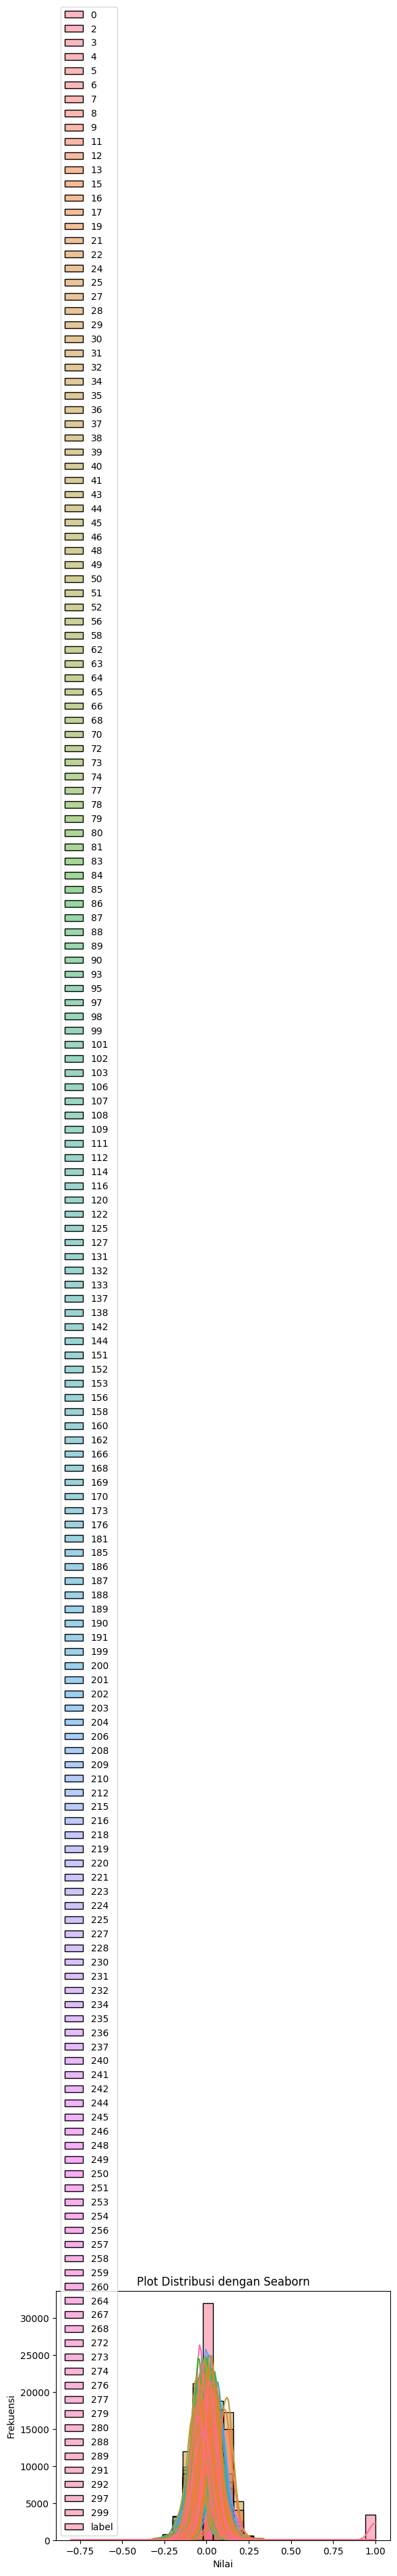

In [11]:
sb.histplot(data_text, bins=30, kde=True)
plt.title('Plot Distribusi dengan Seaborn')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')
plt.show()

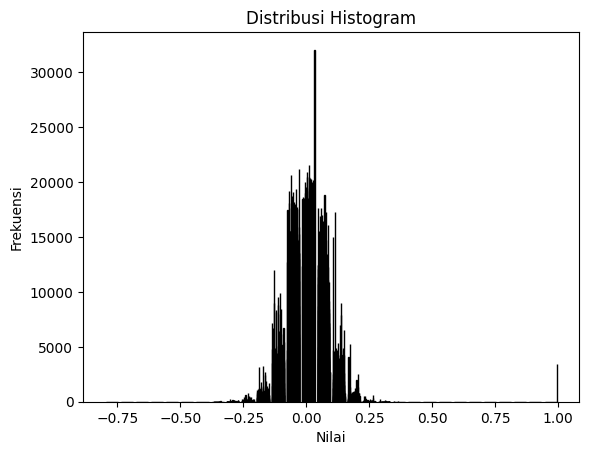

In [12]:
plt.hist(data_text, bins=30, edgecolor='black')
plt.title('Distribusi Histogram')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')
plt.show()

# Content Based Features

In [13]:
data_content = data.drop(['dataset','Word2vec'], axis=1)

In [14]:
data_content.head(2)

,label,nurls,encoding,nparts,hasHTML,attachments,badwords,ipurls,diffhref,forms,...,distinct_words,char_count,word_count,richness,RE_presence,link_images,named_urls,lemmatized,stemmed,joinedLem
0,0.0,0,7bit,1,0,0,0,0,0,0,...,29,131,34,0.257576,0,0,0,"[able, access, report, second, time, ask, plea...","[abl, access, report, second, time, ask, pleas...","able,access,report,second,time,ask,please,open..."
1,1.0,0,none,2,0,1,0,0,0,0,...,25,126,25,0.196850,0,0,0,"[account, close, many, fail, login, attempt, p...","[account, close, mani, fail, login, attempt, p...","account,close,many,fail,login,attempt,please,d..."


In [15]:
data_content.dtypes

label               float32
nurls                 int32
encoding             object
nparts                int32
hasHTML               int32
attachments           int32
badwords              int32
ipurls                int32
diffhref              int32
forms                 int32
scripts               int32
ndots                 int32
nports                int32
nrecs                 int32
checkdomains          int32
subject_badwords      int32
script_parts          int32
distinct_words        int32
char_count            int32
word_count            int32
richness            float32
RE_presence           int32
link_images           int32
named_urls            int32
lemmatized           object
stemmed              object
joinedLem            object
dtype: object

In [16]:
# Encoding
encoder = LabelEncoder()
# Lakukan encoding sehingga tipe data object berubah jadi int 
data_content['encoding'] = encoder.fit_transform(data_content.encoding)
data_content['joinedLem'] = encoder.fit_transform(data_content.joinedLem)

data_content.dtypes

label               float32
nurls                 int32
encoding              int32
nparts                int32
hasHTML               int32
attachments           int32
badwords              int32
ipurls                int32
diffhref              int32
forms                 int32
scripts               int32
ndots                 int32
nports                int32
nrecs                 int32
checkdomains          int32
subject_badwords      int32
script_parts          int32
distinct_words        int32
char_count            int32
word_count            int32
richness            float32
RE_presence           int32
link_images           int32
named_urls            int32
lemmatized           object
stemmed              object
joinedLem             int32
dtype: object

In [17]:
label = data_content['label']
#labelnya diubah jadi integer soalnya sebelumnya dia float
label = np.array(label, dtype=int)
# masukin kolom label di data barunya
data_content['label'] = label

In [18]:
corr = data_content.corr()

abs_corr = abs(corr['label'])
high_corr = abs_corr[abs_corr > 0.15]

chosen_features = [col for col in data_content.columns if col in high_corr]

print(abs_corr.loc[abs_corr !=1.0].max())
chosen_features

high_corr

0.8991262299807757


label               1.000000
encoding            0.464476
nparts              0.391113
hasHTML             0.899126
attachments         0.236914
badwords            0.193294
ipurls              0.262165
ndots               0.525796
checkdomains        0.399761
subject_badwords    0.315927
RE_presence         0.174932
Name: label, dtype: float64

<AxesSubplot:>

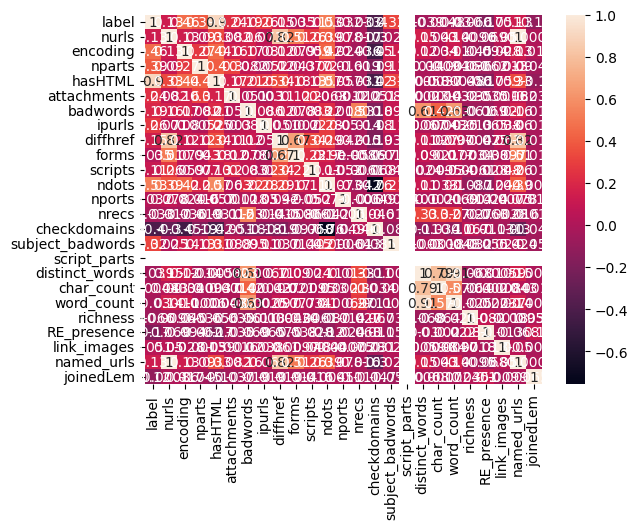

In [19]:
sb.heatmap(data=corr, annot=True)

In [20]:
data_content = data_content[chosen_features]
data_content2 = data_content.drop(['label'], axis=1)
#training set hanya w2v features
X=data_content.drop(['label'], axis=1)
#testing set yang label only
y=data_content['label']

In [21]:
data_content.head(10)

,label,encoding,nparts,hasHTML,attachments,badwords,ipurls,ndots,checkdomains,subject_badwords,RE_presence
0,0,0,1,0,0,0,0,0,1,0,0
1,1,4,2,0,1,0,0,0,1,0,0
2,1,4,2,1,0,0,0,2,0,0,0
3,0,0,1,0,0,0,0,0,1,0,1
4,0,0,1,0,0,2,0,0,1,0,0
5,0,1,1,0,0,0,0,1,0,0,1
6,0,0,1,0,0,0,0,0,1,0,1
7,0,0,1,0,0,0,0,0,1,0,0
8,0,0,1,0,0,0,0,0,1,0,1
9,0,0,1,0,0,0,0,0,1,0,0


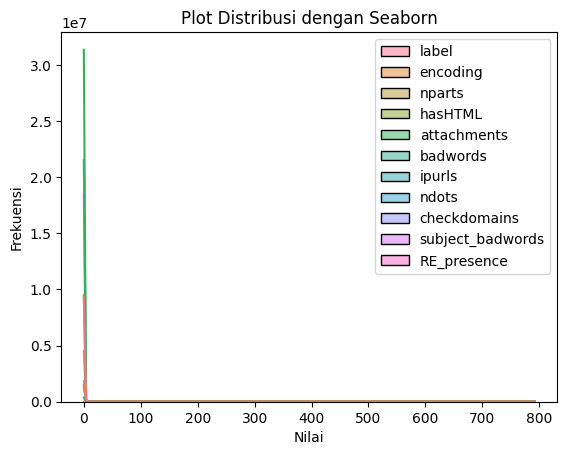

In [22]:
sb.histplot(data_content, bins=30, kde=True)
plt.title('Plot Distribusi dengan Seaborn')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')
plt.show()


In [23]:
data_content.describe()

,label,encoding,nparts,hasHTML,attachments,badwords,ipurls,ndots,checkdomains,subject_badwords,RE_presence
count,35511.000000,35511.000000,35511.000000,35511.000000,35511.000000,35511.000000,35511.000000,35511.000000,35511.000000,35511.000000,35511.000000
mean,0.097575,0.784067,1.065332,0.092704,0.008026,1.374813,0.016108,0.964096,0.734533,0.023317,0.312354
std,0.296744,1.651128,0.452921,0.290021,0.096213,5.711996,0.139071,1.669776,0.441588,0.161370,0.463460
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000
max,1.000000,5.000000,21.000000,1.000000,5.000000,792.000000,5.000000,28.000000,1.000000,3.000000,1.000000


In [24]:
data_content.head(2)

,label,encoding,nparts,hasHTML,attachments,badwords,ipurls,ndots,checkdomains,subject_badwords,RE_presence
0,0,0,1,0,0,0,0,0,1,0,0
1,1,4,2,0,1,0,0,0,1,0,0


In [25]:
y

0        0
1        1
2        1
3        0
4        0
        ..
35506    0
35507    0
35508    0
35509    0
35510    1
Name: label, Length: 35511, dtype: int32

# Gathering Data

In [26]:
#Concat word2vec pakai content-based features TRAINING 
data_concat = pd.concat([data_content2, data_text], axis=1)
X_concat=data_concat.drop(['label'], axis=1)
y_concat=data_concat['label']

data_concat.head()

,encoding,nparts,hasHTML,attachments,badwords,ipurls,ndots,checkdomains,subject_badwords,RE_presence,...,277,279,280,288,289,291,292,297,299,label
0,0,1,0,0,0,0,0,1,0,0,...,-0.029340,0.126633,-0.018892,0.086408,0.132406,-0.080238,-0.005518,-0.047493,-0.093437,0
1,4,2,0,1,0,0,0,1,0,0,...,-0.057502,0.171999,-0.002052,0.093063,0.154246,-0.104749,0.033405,0.018433,-0.075090,1
2,4,2,1,0,0,0,2,0,0,0,...,-0.050360,0.053392,-0.021524,-0.000819,0.097126,-0.104136,0.009361,0.051664,-0.029602,1
3,0,1,0,0,0,0,0,1,0,1,...,-0.057516,0.028077,-0.015266,-0.011353,-0.014364,0.012128,-0.013124,-0.061996,-0.054623,0
4,0,1,0,0,2,0,0,1,0,0,...,-0.036947,-0.026703,0.074493,0.008019,-0.006293,0.043286,0.056521,-0.028916,-0.028121,0


In [27]:
y_concat

0        0
1        1
2        1
3        0
4        0
        ..
35506    0
35507    0
35508    0
35509    0
35510    1
Name: label, Length: 35511, dtype: int32

In [28]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_concat, y_concat, test_size=0.3,random_state=3)

In [29]:
print(X_train1.shape)
print(y_train1.shape)

(24857, 188)
(24857,)


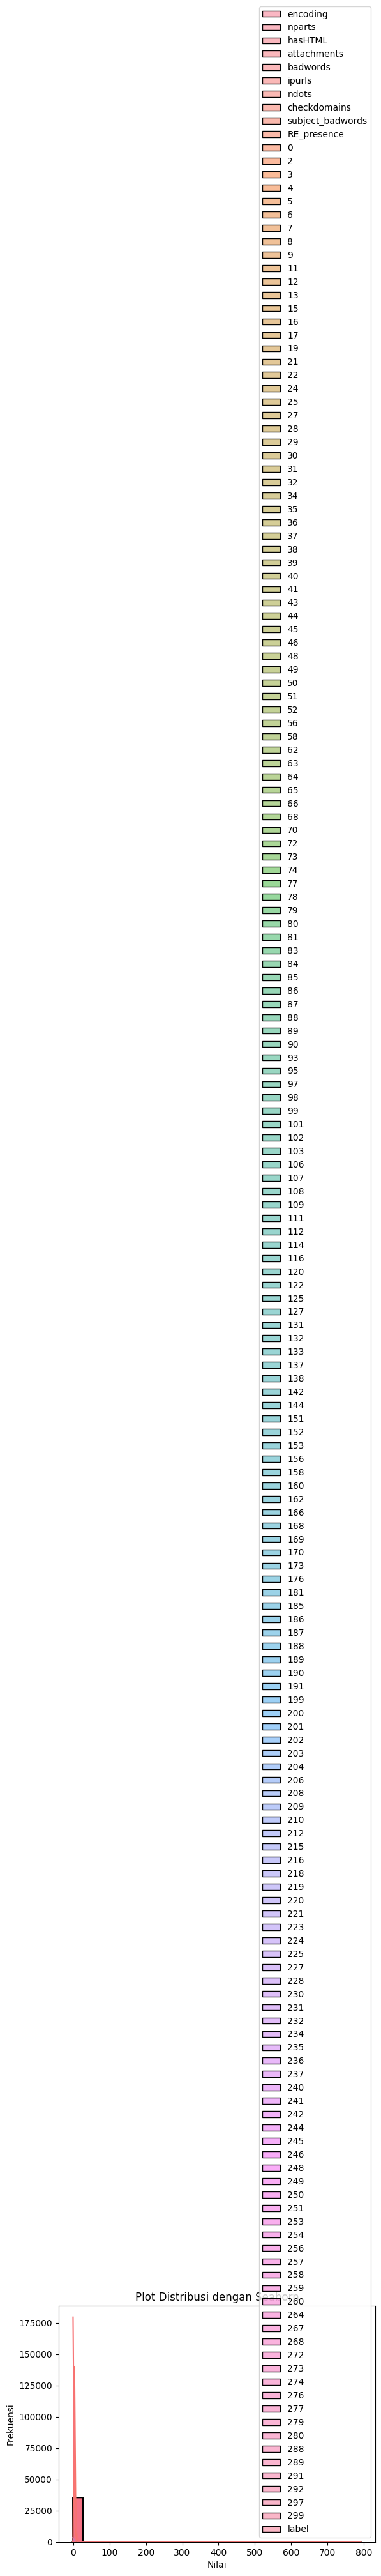

In [30]:
sb.histplot(data_concat, bins=30, kde=True)
plt.title('Plot Distribusi dengan Seaborn')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')
plt.show()

# Classification

Support Vector Machine

In [31]:
X_train_a= X_train1.iloc[:, :10]
X_Test_a= X_test1.iloc[:, :10]

X_Test_a.shape


(10654, 10)

In [32]:
X_train_a.dtypes

encoding            int32
nparts              int32
hasHTML             int32
attachments         int32
badwords            int32
ipurls              int32
ndots               int32
checkdomains        int32
subject_badwords    int32
RE_presence         int32
dtype: object

In [33]:
X_train_a.shape

(24857, 10)

In [34]:
train0 = np.sum(y_train1==0)
print("Jumlah label train ham       : ", train0)

train1 = np.sum(y_train1==1)
print("Jumlah label trin phishing   : ", train1)

test0 = np.sum(y_test1==0)
print("Jumlah label test ham        : ", test0)

test1 = np.sum(y_test1==1)
print("Jumlah label test phishing   : ", test1)

Jumlah label train ham       :  22427
Jumlah label trin phishing   :  2430
Jumlah label test ham        :  9619
Jumlah label test phishing   :  1035


In [35]:
# buat classifier SVM
svm = SVC(C=1/(2*0.5), 
          class_weight='balanced', 
          max_iter=1000, 
          probability=True)

# beginning time
btime_svm = time.time()

In [36]:

# Train pakai training set
svm.fit(X_train_a, y_train1)

c:\Users\bcamaster\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(class_weight='balanced', max_iter=1000, probability=True)

In [37]:
# ending time
etime_svm = time.time()

# prediksi
y_pred_svm = svm.predict(X_Test_a)

In [38]:
print("--------------- SVM RESULT ------------------")
print("\nConfusion Matrix : ")
print(confusion_matrix(y_test1,y_pred_svm))
print("\nClassification Report : ")
print(classification_report(y_test1, y_pred_svm, digits=4))
print('\nAccuracy Score: %.4f' %accuracy_score(y_test1, y_pred_svm))
print('\nF1 Score: %.4f' %f1_score(y_test1,y_pred_svm, average='micro'))        
print ('\nAUC: %.4f' %roc_auc_score(y_test1, y_pred_svm)) 
print("\nTraining time (in second): %.4f" %(etime_svm-btime_svm))

--------------- SVM RESULT ------------------

Confusion Matrix : 
[[8251 1368]
 [  34 1001]]

Classification Report : 
              precision    recall  f1-score   support

           0     0.9959    0.8578    0.9217      9619
           1     0.4225    0.9671    0.5881      1035

    accuracy                         0.8684     10654
   macro avg     0.7092    0.9125    0.7549     10654
weighted avg     0.9402    0.8684    0.8893     10654


Accuracy Score: 0.8684

F1 Score: 0.8684

AUC: 0.9125

Training time (in second): 19.7335


<AxesSubplot:>

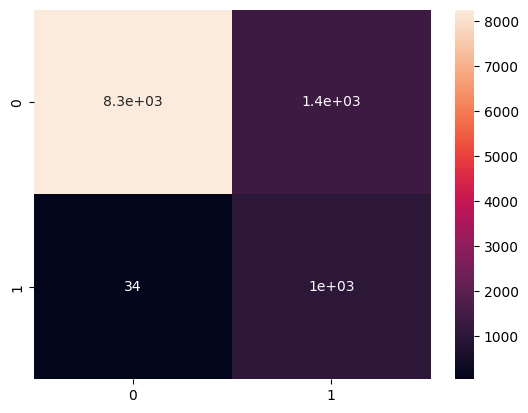

In [39]:
sb.heatmap(data = confusion_matrix(y_test1,y_pred_svm), annot = True)

MLP Classifier (Neural Network)

In [40]:
X_train_b= X_train1.iloc[:,10:]
X_Test_b= X_test1.iloc[:,10:]


In [41]:
mlp = MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 100, 50), solver='adam', alpha=0.5, learning_rate='adaptive', max_iter=1000)
btime_mlp = time.time()

In [42]:
#Train the model using the training sets
mlp.fit(X_train_b, y_train1)

MLPClassifier(activation='tanh', alpha=0.5, hidden_layer_sizes=(50, 100, 50),
              learning_rate='adaptive', max_iter=1000)

In [43]:
etime_mlp = time.time()

#Predict the response for test dataset
y_pred_mlp = mlp.predict(X_Test_b)

In [44]:
print("--------------- MLP RESULT ------------------")
print("\nConfusion Matrix : ")
print(confusion_matrix(y_test1,y_pred_mlp))
print("\nClassification Report : ")
print(classification_report(y_test1, y_pred_mlp, digits=4))
print('\nAccuracy Score: %.4f' %accuracy_score(y_test1,y_pred_mlp))
print('\nF1 Score: %.4f' %f1_score(y_test1,y_pred_mlp, average='micro'))        
print ('\nAUC: %.4f' %roc_auc_score(y_test1, y_pred_mlp)) 
print("\nTraining time (in second): %.4f" %(etime_mlp-btime_mlp))

--------------- MLP RESULT ------------------

Confusion Matrix : 
[[9542   77]
 [ 133  902]]

Classification Report : 
              precision    recall  f1-score   support

           0     0.9863    0.9920    0.9891      9619
           1     0.9213    0.8715    0.8957      1035

    accuracy                         0.9803     10654
   macro avg     0.9538    0.9317    0.9424     10654
weighted avg     0.9799    0.9803    0.9800     10654


Accuracy Score: 0.9803

F1 Score: 0.9803

AUC: 0.9317

Training time (in second): 33.5339


<AxesSubplot:>

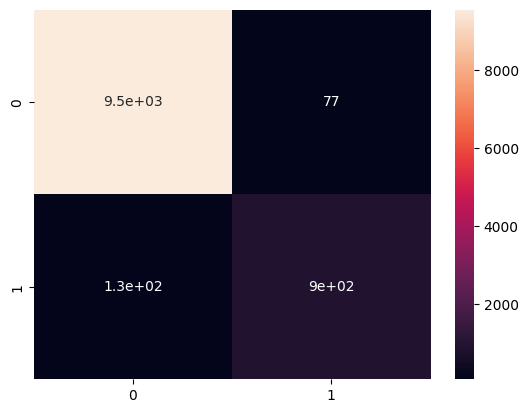

In [45]:
sb.heatmap(data = confusion_matrix(y_test1,y_pred_mlp), annot = True)

# Soft Voting Classifier

In [46]:
# Pisahin datanya menjadi content based dan text based
X_train_a, X_train_b = X_train1.iloc[:, :10], X_train1.iloc[:,10:]
X_test_a, X_test_b = X_test1.iloc[:, :10], X_test1.iloc[:,10:]

# y_train1, y_train2 = y_train.iloc[:,0:18], y_train.iloc[:,18:259]
# y_test1, y_test2 = y_test.iloc[:,0:18], y_test.iloc[:,18:259]

X_train_list = [X_train_a, X_train_b]
X_test_list = [X_test_a, X_test_b]

# y_train_list = [y_train1, y_train2]
# y_test_list = [y_test1, y_test2]


In [47]:
classifiers = [('svm',  svm), ('mlp', mlp)]
btime_vote = time.time()
fitted_estimators, label_encoder = multiple_estimators(classifiers, X_train_list, y_train1)

c:\Users\bcamaster\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


In [48]:
etime_vote = time.time()
y_pred_voting = predict_from_multiple_estimators(fitted_estimators, label_encoder, X_test_list)

In [49]:
print("--------------- SOFT VOTING RESULT ------------------")
print("\nConfusion Matrix : ")
print(confusion_matrix(y_test1,y_pred_voting))
print("\nClassification Report : ")
print(classification_report(y_test1, y_pred_voting, digits=4))
print('\nF1 Score: %.4f' %f1_score(y_test1,y_pred_voting, average='micro')) 
print('\nAccuracy Score: %.4f' %accuracy_score(y_test1,y_pred_voting))
print ('\nAUC: %.4f' %roc_auc_score(y_test1, y_pred_voting))
print("\nTraining time Sec: %.4f" %(etime_vote-btime_vote))

--------------- SOFT VOTING RESULT ------------------

Confusion Matrix : 
[[9615    4]
 [ 141  894]]

Classification Report : 
              precision    recall  f1-score   support

           0     0.9855    0.9996    0.9925      9619
           1     0.9955    0.8638    0.9250      1035

    accuracy                         0.9864     10654
   macro avg     0.9905    0.9317    0.9588     10654
weighted avg     0.9865    0.9864    0.9860     10654


F1 Score: 0.9864

Accuracy Score: 0.9864

AUC: 0.9317

Training time Sec: 52.8107


<AxesSubplot:>

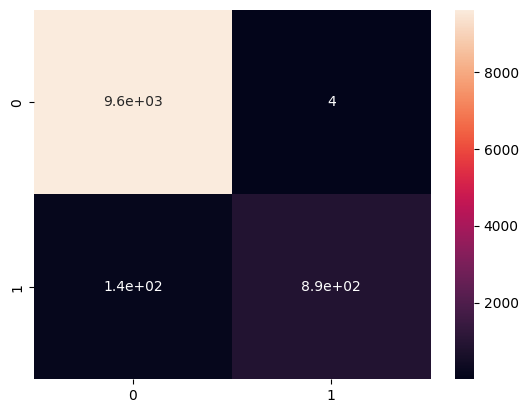

In [50]:
sb.heatmap(data = confusion_matrix(y_test1,y_pred_voting), annot = True)

In [51]:
X_test1.iloc[:,10:188]

,0,2,3,4,5,6,7,8,9,11,...,276,277,279,280,288,289,291,292,297,299
18514,0.020222,-0.038177,0.113589,0.012729,0.015859,-0.100388,0.087648,-0.089257,0.081388,-0.083320,...,-0.068268,-0.044196,-0.033160,0.033366,-0.036857,-0.021974,0.068058,0.102112,-0.126502,0.079654
337,0.009741,0.050660,0.023390,-0.004501,-0.208864,0.009775,-0.070599,-0.006542,0.074865,-0.085077,...,-0.011497,-0.032233,-0.015337,0.055643,-0.049563,0.056415,0.042521,-0.127892,-0.035315,0.011751
8450,0.003400,0.017935,0.098617,0.035171,-0.006436,-0.056288,-0.040710,-0.075095,0.017722,-0.066698,...,0.010362,-0.023846,0.009020,0.029665,0.024968,-0.040873,-0.029320,0.038807,-0.038836,-0.063623
26933,-0.069267,0.017412,-0.049962,-0.029570,-0.036173,0.014058,-0.094602,0.016580,-0.062404,-0.037660,...,-0.006282,-0.038693,0.051627,-0.012428,-0.020711,0.019663,-0.102071,-0.009610,-0.012435,-0.042556
2049,0.015489,0.030506,0.086621,-0.035330,-0.020824,-0.044916,0.023926,0.019177,0.041739,-0.056935,...,-0.028664,-0.030251,-0.006010,-0.003888,-0.014405,-0.032095,0.033341,0.042614,-0.111087,0.038853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11860,0.016617,0.016379,-0.077856,-0.042272,-0.049267,0.041918,-0.094207,0.046937,-0.020206,-0.008761,...,0.016045,-0.047661,0.036748,-0.066507,0.042915,0.044376,-0.060453,0.010528,-0.045848,-0.007395
22336,0.002799,0.008050,0.083504,0.008154,-0.001410,-0.110211,0.029113,-0.118585,0.052887,0.009113,...,-0.041538,-0.076364,-0.051427,0.069303,-0.003161,0.013137,0.103939,0.048739,-0.141413,-0.022451
5620,0.005961,0.005519,-0.073569,-0.005834,-0.023878,0.068091,-0.047529,0.050966,-0.029942,0.054946,...,0.029971,-0.028377,0.064227,-0.009212,-0.034319,0.037991,-0.062847,0.011457,0.027241,-0.061326
29717,-0.030932,-0.005365,-0.026418,-0.074115,-0.006362,0.052674,-0.068175,0.090644,-0.035122,0.014333,...,0.048105,-0.057671,0.035979,-0.047061,0.012114,0.014854,-0.093018,-0.024353,0.016347,-0.053512


# Stacking Classifier

In [52]:
pipe_svm = make_pipeline(ColumnSelector(cols=(0,1,2,3,4,5,6,7,8,9,10)),
                      SVC(C=1, class_weight='balanced', max_iter=1000, probability=True))

pipe_mlp = make_pipeline(ColumnSelector(cols=(11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187)),
                                        # , 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259)),
                      MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 100, 50), solver='adam', alpha=0.5, learning_rate='adaptive', max_iter=1000))



In [53]:
print(X_train1.shape)


(24857, 188)


In [54]:
# Verify the max column index in X_train1
max_column_index = X_train1.shape[1] - 1
print(f"Max column index in X_train1: {max_column_index}")

# Check the column indices in ColumnSelector
print(f"Column indices for SVM: {list(range(0, 11))}")
print(f"Column indices for MLP: {list(range(11, 189))}")


Max column index in X_train1: 187
Column indices for SVM: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Column indices for MLP: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188]


In [55]:
stacking = StackingClassifier(classifiers=[pipe_svm, pipe_mlp], 
                          meta_classifier=LogisticRegression(C=1), 
                          use_probas = True,
                          )

btime_stack = time.time()


In [56]:
stacking = stacking.fit(X_train1, y_train1)


c:\Users\bcamaster\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


In [57]:
etime_stack = time.time()
y_pred_stacked = stacking.predict(X_test1)

In [58]:
print("--------------- STACKING RESULT ------------------")
print("\nConfusion Matrix : ")
print(confusion_matrix(y_test1,y_pred_stacked)) 
print("\nClassification Report : ")
print(classification_report(y_test1, y_pred_stacked, digits=4))
print('\nF1 Score: %.4f' %f1_score(y_test1,y_pred_stacked, average='micro'))
print('\nAccuracy Score: %.4f' %accuracy_score(y_test1,y_pred_stacked))
print ('\nAUC: %.4f' %roc_auc_score(y_test1, y_pred_stacked))
print("\nTraining time Sec: %.4f" %(etime_stack-btime_stack))

--------------- STACKING RESULT ------------------

Confusion Matrix : 
[[9583   36]
 [  87  948]]

Classification Report : 
              precision    recall  f1-score   support

           0     0.9910    0.9963    0.9936      9619
           1     0.9634    0.9159    0.9391      1035

    accuracy                         0.9885     10654
   macro avg     0.9772    0.9561    0.9664     10654
weighted avg     0.9883    0.9885    0.9883     10654


F1 Score: 0.9885

Accuracy Score: 0.9885

AUC: 0.9561

Training time Sec: 76.8981


<AxesSubplot:>

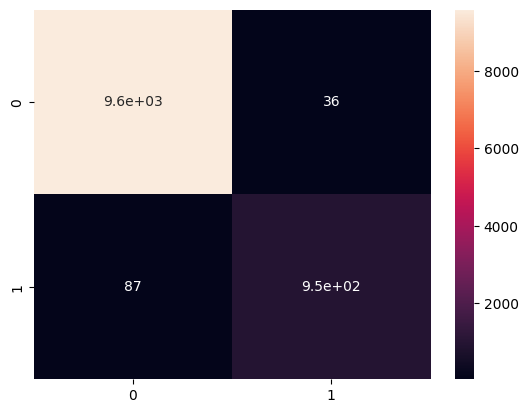

In [59]:
sb.heatmap(data = confusion_matrix(y_test1,y_pred_stacked), annot = True)

# Plotting

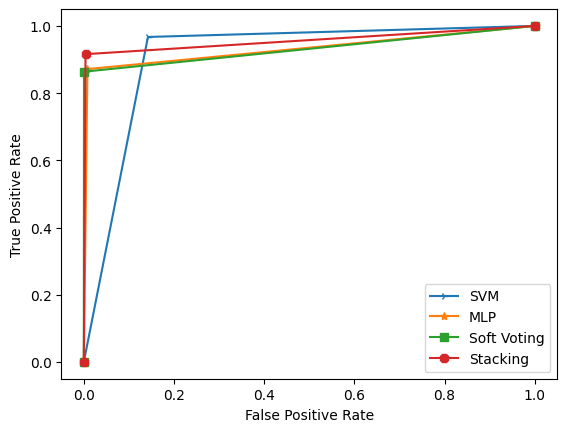

In [60]:
#plot svm
fpr_knn, tpr_knn, threshold = roc_curve(y_test1, y_pred_svm)
pyplot.plot(fpr_knn, tpr_knn, marker='4', label='SVM')

#plot MLP
fpr_mlp, tpr_mlp, threshold = roc_curve(y_test1, y_pred_mlp)
pyplot.plot(fpr_mlp, tpr_mlp, marker='*', label='MLP')

#plot voting
fpr_voting, tpr_voting, threshold = roc_curve(y_test1, y_pred_voting)
pyplot.plot(fpr_voting, tpr_voting, marker='s', label='Soft Voting')

#plot stacking
fpr_stacked, tpr_stacked, threshold = roc_curve(y_test1, y_pred_stacked)
pyplot.plot(fpr_stacked, tpr_stacked, marker='8', label='Stacking')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

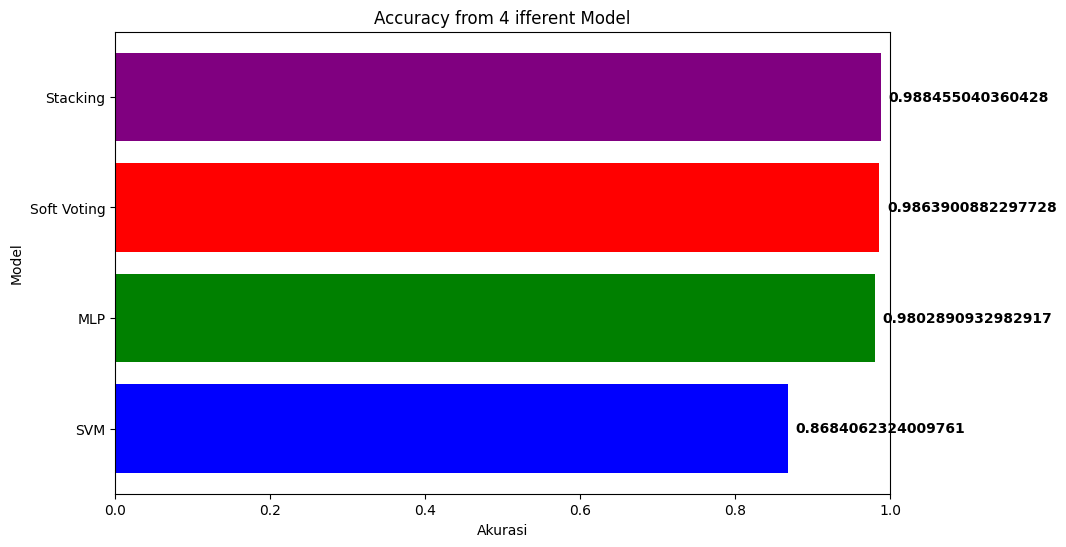

In [61]:
models = ['SVM', 'MLP', 'Soft Voting', 'Stacking']
accuracies = [accuracy_score(y_test1,y_pred_svm), 
            accuracy_score(y_test1,y_pred_mlp),
            accuracy_score(y_test1,y_pred_voting),
            accuracy_score(y_test1,y_pred_stacked),
            ]

plt.figure(figsize=(10, 6))
plt.barh(models, accuracies, color=['blue', 'green', 'red', 'purple'])

plt.title('Accuracy from 4 ifferent Model')
plt.xlabel('Akurasi')
plt.ylabel('Model')

for i, v in enumerate(accuracies):
    plt.text(v + 0.01, i, str(v), va='center', fontweight='bold')

plt.xlim(0, 1)
plt.show()

# Additional

Correlation (Content)

In [62]:
data_content = data.drop(['dataset','Word2vec'], axis=1)

In [63]:
corr = data_content.corr()

abs_corr = abs(corr['label'])
abs_corr = abs(corr['label']).drop('label')
print(abs_corr)

nurls               0.133858
nparts              0.391113
hasHTML             0.899126
attachments         0.236914
badwords            0.193294
ipurls              0.262165
diffhref            0.146311
forms               0.035487
scripts             0.107381
ndots               0.525796
nports              0.031671
nrecs               0.033189
checkdomains        0.399761
subject_badwords    0.315927
script_parts             NaN
distinct_words      0.039452
char_count          0.004816
word_count          0.029529
richness            0.066427
RE_presence         0.174932
link_images         0.050568
named_urls          0.130992
Name: label, dtype: float64


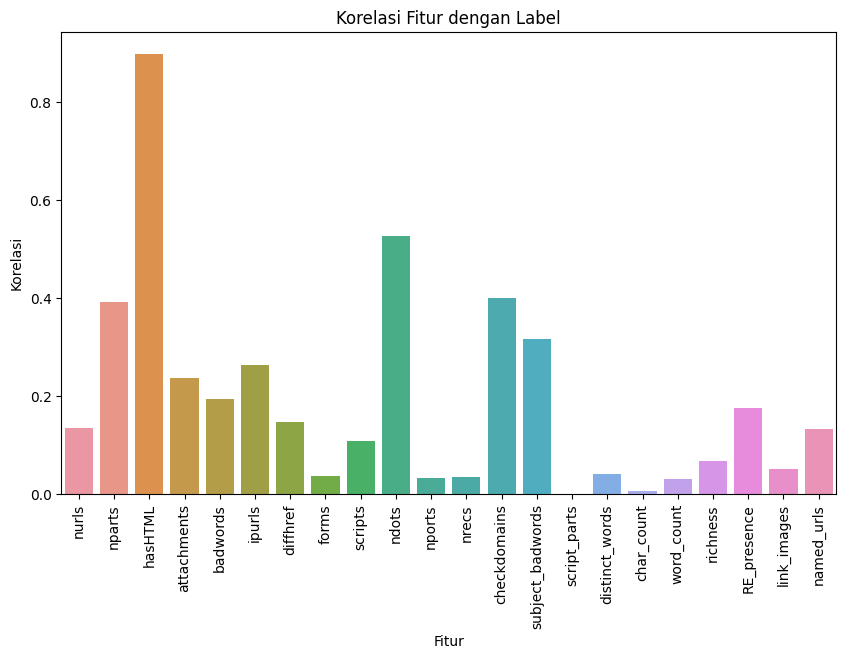

In [64]:
abs_corr_data = abs_corr.reset_index()
abs_corr_data.columns = ['Feature', 'Correlation']

plt.figure(figsize=(10, 6))
sb.barplot(x='Feature', y='Correlation', data=abs_corr_data)
plt.xticks(rotation=90)
plt.title('Korelasi Fitur dengan Label')
plt.xlabel('Fitur')
plt.ylabel('Korelasi')
plt.show()

In [65]:
high_corr = abs_corr[abs_corr > 0.15]
chosen_features = [col for col in data_content.columns if col in high_corr]

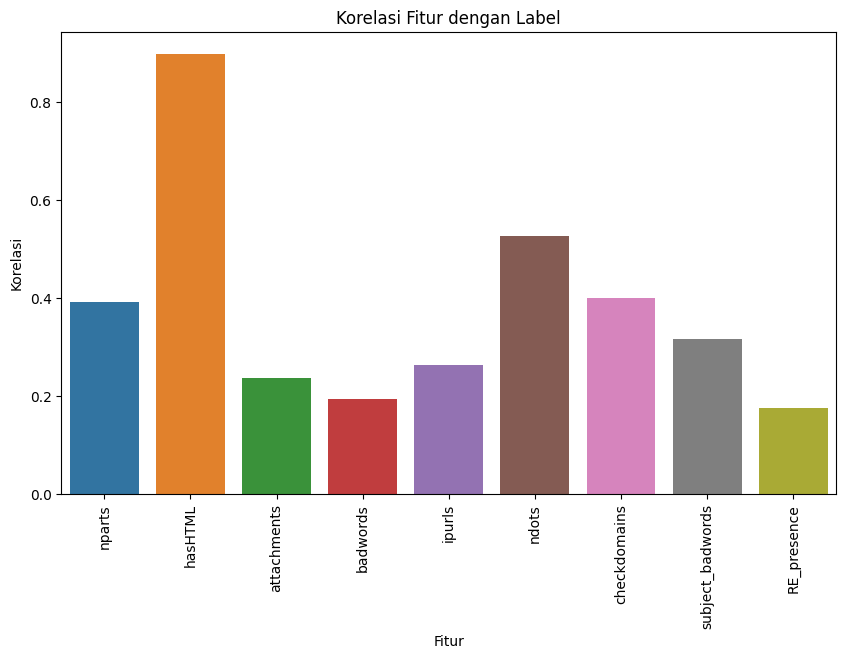

In [66]:
high_corr_data = high_corr.reset_index()
high_corr_data.columns = ['Feature', 'Correlation']

plt.figure(figsize=(10, 6))
sb.barplot(x='Feature', y='Correlation', data=high_corr_data)
plt.xticks(rotation=90)
plt.title('Korelasi Fitur dengan Label')
plt.xlabel('Fitur')
plt.ylabel('Korelasi')
plt.show()

Correlation (Text)

In [67]:
# Word2Vec features
count = 0
word = data['Word2vec']

arr = []
c = 0

for i in word:
    arr.append(i['values'])

# Convert array yang punya Word2Vec features ke numpy
arr = np.array(arr)

data_text = pd.DataFrame(arr)
data_text.head(2)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.036448,0.058101,0.065896,0.069580,-0.123951,-0.106723,0.062743,-0.036808,0.153624,0.01753,...,0.117266,-0.080238,-0.005518,-0.090789,0.067821,-0.048266,-0.030692,-0.047493,0.100811,-0.093437
1,-0.129006,0.057079,-0.005884,-0.011066,-0.054681,0.026852,0.083121,-0.050792,0.148355,-0.05223,...,0.043703,-0.104749,0.033405,-0.044135,0.028539,-0.085285,-0.025147,0.018433,0.090643,-0.075090


In [68]:
label = data['label']
#labelnya diubah jadi integer soalnya sebelumnya dia float
label = np.array(label, dtype=int)
# masukin kolom label di data barunya
data_text['label'] = label

In [69]:
corr = data_text.corr()

abs_corr = abs(corr['label'])
abs_corr = abs(corr['label']).drop('label')
print(abs_corr)

0      0.314263
1      0.036993
2      0.212019
3      0.285108
4      0.161219
         ...   
295    0.084001
296    0.067082
297    0.212096
298    0.129760
299    0.159276
Name: label, Length: 300, dtype: float64


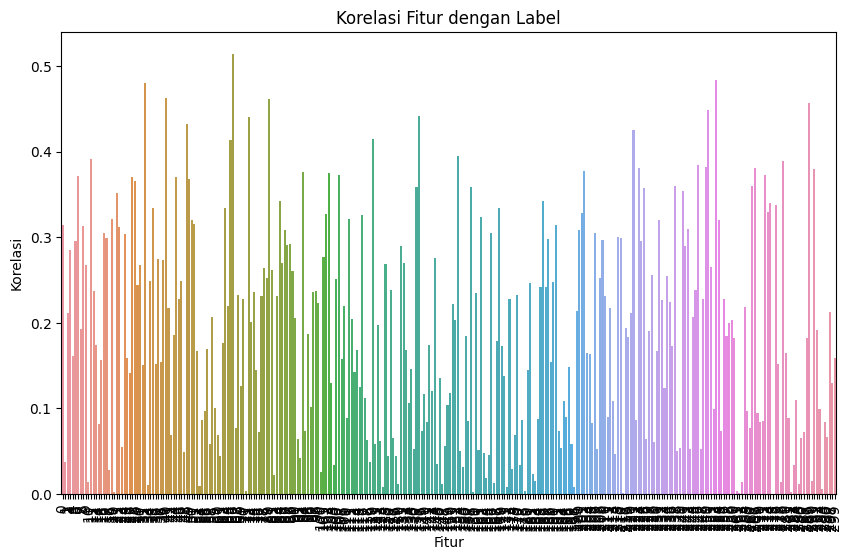

In [70]:
abs_corr_data = abs_corr.reset_index()
abs_corr_data.columns = ['Feature', 'Correlation']

plt.figure(figsize=(10, 6))
sb.barplot(x='Feature', y='Correlation', data=abs_corr_data)
plt.xticks(rotation=90)
plt.title('Korelasi Fitur dengan Label')
plt.xlabel('Fitur')
plt.ylabel('Korelasi')
plt.show()

In [71]:
high_corr = abs_corr[abs_corr > 0.15]
chosen_features = [col for col in data_content.columns if col in high_corr]

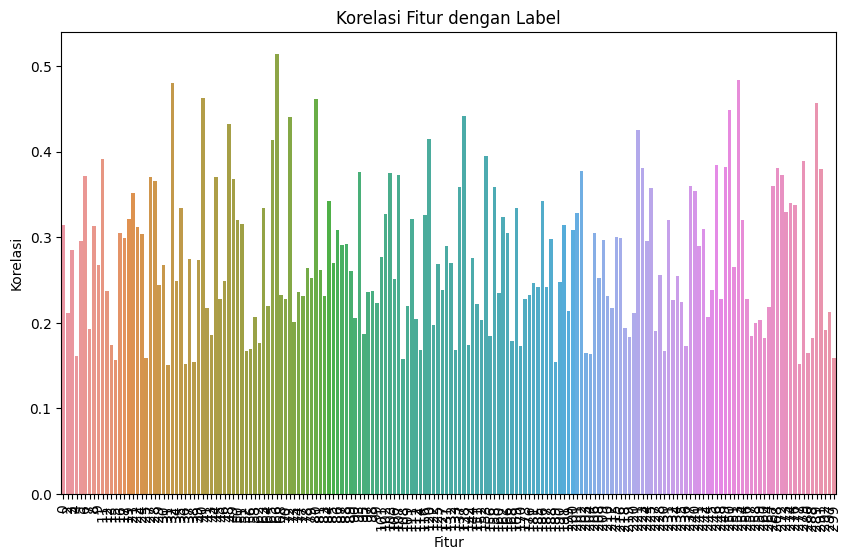

In [72]:
high_corr_data = high_corr.reset_index()
high_corr_data.columns = ['Feature', 'Correlation']

plt.figure(figsize=(10, 6))
sb.barplot(x='Feature', y='Correlation', data=high_corr_data)
plt.xticks(rotation=90)
plt.title('Korelasi Fitur dengan Label')
plt.xlabel('Fitur')
plt.ylabel('Korelasi')
plt.show()